# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

# Mounting Google Drive locally

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [3]:
# using SQLite Table to read data.
con = sqlite3.connect("/content/gdrive/My Drive/Dataset/database.sqlite") 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

#Using a sample size of 100k datapoints and applyTruncated-SVD on TFIDF
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [0]:

print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [0]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [0]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [8]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [9]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [7]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [9]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [13]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [10]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [0]:

# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [16]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [17]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [18]:

#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't","isnt", "isn", "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [14]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 87773/87773 [00:27<00:00, 3154.02it/s]


In [15]:
preprocessed_reviews[0]

'dogs loves chicken product china wont buying anymore hard find chicken products made usa one bad good product wont take chances till know going china imports'

In [0]:
final["CleanText"] = [preprocessed_reviews[i] for i in range(len(final))]

In [23]:
final.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanText
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...,dogs loves chicken product china wont buying a...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dogs love saw pet store tag attached regarding...


In [0]:
final_new = final[final.CleanText != '']

In [18]:
a=0
for qu1 in list(final_new['CleanText']):
    if len(list(qu1))==0:
        print(final_new[final_new['CleanText']== qu1])
        a+=1 
print(a)

0


In [19]:
len(final)

87773

In [27]:
len(final_new)

87557

In [0]:
final_new["CleanText"] = [preprocessed_reviews[i] for i in range(len(final_new))]

In [21]:
final_new.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanText
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...,dogs loves chicken product china wont buying a...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dogs love saw pet store tag attached regarding...


In [22]:
j=0
for i in preprocessed_reviews:
    if i == '':
        j+=1
print(j)

216


In [0]:
# Remove empty strings from list of strings
while("" in preprocessed_reviews) :
    preprocessed_reviews.remove("")

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [0]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [0]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 12997)
the number of unique words  12997


## [4.2] Bi-Grams and n-Grams.

In [0]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

In [24]:
tf_idf_vect = TfidfVectorizer(use_idf = True)
tf_idf_vect.fit(final_new["CleanText"].values)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(final_new["CleanText"].values)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
#print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaaarrrrrggghhh', 'aaaaaawwwwwwwwww', 'aaaaah']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (87557, 54842)


## [4.4] Word2Vec

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [0]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('snack', 0.9951335191726685), ('calorie', 0.9946465492248535), ('wonderful', 0.9946032166481018), ('excellent', 0.9944332838058472), ('especially', 0.9941144585609436), ('baked', 0.9940600395202637), ('salted', 0.994047224521637), ('alternative', 0.9937226176261902), ('tasty', 0.9936816692352295), ('healthy', 0.9936649799346924)]
[('varieties', 0.9994194507598877), ('become', 0.9992934465408325), ('popcorn', 0.9992750883102417), ('de', 0.9992610216140747), ('miss', 0.9992451071739197), ('melitta', 0.999218761920929), ('choice', 0.9992102384567261), ('american', 0.9991837739944458), ('beef', 0.9991780519485474), ('finish', 0.9991567134857178)]


In [0]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [0]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:03<00:00, 1330.47it/s]


4986
50


#### [4.4.1.2] TFIDF weighted W2v

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:20<00:00, 245.63it/s]


## Truncated-SVD

Reference Blogs:<a href='https://medium.com/data-science-group-iitr/word-embedding-2d05d270b285'>blog-1,</a> <a href='https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/'>blog-2

### [5.1] Taking top features from TFIDF,<font color='red'> SET 2</font>

* if the word is occurring more in the corpus then we will get idf value less and

* if we have a rare word in the corpus then we have idf value more. 

In [25]:
# Get feature names from tfidf
features = tf_idf_vect.get_feature_names()
# feature weights based on idf score
coef = tf_idf_vect.idf_  #The inverse document frequency (IDF) vector
# Store features with their idf score in a dataframe
co_matrix_df = pd.DataFrame({'Features' : features, 'Idf_score' : coef})
co_matrix_df = co_matrix_df.sort_values("Idf_score", ascending = True)[:3000] #Taking top 3000 features from tf-idf vectorizers using idf_ score.
print("shape of selected features :", co_matrix_df.shape)
print("Top features :\n\n",co_matrix_df[:10])

shape of selected features : (3000, 2)
Top features :

       Features  Idf_score
32340      not   1.605192
27456     like   2.198294
20395     good   2.312836
20847    great   2.411812
33318      one   2.501118
47789    taste   2.515726
53982    would   2.592148
37616  product   2.652829
28092     love   2.681443
17991   flavor   2.697403


### [5.2] Calulation of Co-occurrence matrix

In [0]:
#creating an empty a[3000][3000] matrix with all zeros
zero = np.zeros((len(co_matrix_df["Features"].values), len(co_matrix_df["Features"].values)),dtype=int)

In [0]:
#Creating a DataFrame with index = co_matrix_df["Features"].values and columns = co_matrix_df["Features"].values
df_zero = pd.DataFrame(zero, index = co_matrix_df["Features"].values, columns = co_matrix_df["Features"].values)

In [28]:
#Blog 1: https://medium.com/data-science-group-iitr/word-embedding-2d05d270b285
#Blog 2: https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/
#enumerate() Sendex:https://www.youtube.com/watch?v=bOGmYvtw-kk
#Pandas .loc[] DataSchool:https://www.youtube.com/watch?v=xvpNA7bC8cs
#https://stackoverflow.com/questions/41661801/python-calculate-the-co-occurrence-matrix?noredirect=1&lq=1
#Common Vectorizer usage: https://scikit-learn.org/stable/modules/feature_extraction.html#common-vectorizer-usage
#df_zero:  https://imgur.com/AbyE9rp
#with "window" threshold size we can move forward and backward

%time
window = 4
for sent in tqdm(final_new["CleanText"].values):
    word = sent.split(" ")
    for idx, dumb in enumerate(word):
            for j in range(max(idx-window,0),min(idx+window,len(word))):
                if (word[j] != word[idx]):
                        try:
                            df_zero.loc[word[idx], word[j]] += 1
                            df_zero.loc[word[j], word[idx]] += 1
                        except:
                            pass
print(df_zero)

  0%|          | 2/87557 [00:00<1:17:17, 18.88it/s]

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.72 µs


100%|██████████| 87557/87557 [2:44:22<00:00,  8.88it/s]

                 not   like   good  great  ...  grabbed  joke  weruva  coffe
not                0  22087  13131   6653  ...       20    31      44     39
like           22087      0   4332   2481  ...       14    20      29     38
good           13131   4332      0   2496  ...       15    17       8     41
great           6653   2481   2496      0  ...       11     4      11     25
one             9082   3587   2694   1661  ...       32    15      10     18
taste          15163   9787   6385   5470  ...        4     6       0      6
would          12778   4897   3033   1932  ...        8     1      10      7
product         8273   2643   3716   5508  ...        3    10       7     10
love            4587   2011   1659   2282  ...        4     3      33      9
flavor          9828   4378   4066   3922  ...        8     6      26     12
get             7885   1849   1727   1469  ...        4     9       6      8
no              3684   1870   1507   1417  ...        1    56       7      8

In [0]:
dict = df_zero
file = open('/content/gdrive/My Drive/Dataset/pkcl/c_matrix.csv', 'wb')
pickle.dump(dict, file)
file.close()

In [0]:
file = open('/content/gdrive/My Drive/Dataset/pkcl/c_matrix.csv', 'rb')
matrix = pickle.load(file)

In [33]:
matrix.head(2)

,not,like,good,great,one,taste,would,product,love,flavor,get,no,really,much,amazon,time,also,best,buy,little,coffee,price,tried,use,even,find,well,make,food,try,better,eat,first,could,tea,found,used,bought,made,way,...,considerably,toxic,situation,outer,uk,anybody,compliments,simmer,wasabi,ride,wood,mrs,monster,tbsp,acai,automatically,grandmother,safety,beagle,bath,mixer,plump,grease,refuse,ripped,ensure,forced,stirring,gummies,absorb,notch,teriyaki,bills,issimo,pretzel,ruined,grabbed,joke,weruva,coffe
not,0,22087,13131,6653,9082,15163,12778,8273,4587,9828,7885,3684,7570,8099,4091,3828,3967,2718,5767,3065,8544,3657,4196,4178,6863,5617,3919,4014,6273,3843,3157,6488,2637,7635,6117,2355,2160,1620,2245,2364,...,25,69,37,34,35,67,22,19,66,23,32,27,52,20,57,34,17,56,38,24,40,50,72,46,33,51,20,22,63,53,21,65,26,33,68,62,20,31,44,39
like,22087,0,4332,2481,3587,9787,4897,2643,2011,4378,1849,1870,5371,3003,836,1065,2393,1391,1288,2059,5833,852,1449,1395,1750,1018,1358,1440,2697,1722,1684,1455,1057,749,3545,698,969,584,959,1056,...,10,22,4,3,13,16,18,9,54,10,50,20,36,10,28,10,25,12,11,13,5,15,23,9,24,7,16,6,35,15,12,51,3,12,38,4,14,20,29,38


### [5.3] Finding optimal value for number of components (n) to be retained.

I am trying two approaches here to finding the optimal value for number of components (n) 

> ploting cumulative explained variance ratio  #Reference: https://www.appliedaicourse.com/lecture/11/applied-machine-learning-online-course/2896/pca-for-dimensionality-reduction-not-visualization/2/module-2-data-science-exploratory-data-analysis-and-data-visualization

> By using goal level of explained variance  #Reference: https://chrisalbon.com/machine_learning/feature_engineering/select_best_number_of_components_in_tsvd/

In [0]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix

In [0]:
from sklearn.random_projection import sparse_random_matrix

In [0]:
#Reference: https://www.appliedaicourse.com/lecture/11/applied-machine-learning-online-course/2896/pca-for-dimensionality-reduction-not-visualization/2/module-2-data-science-exploratory-data-analysis-and-data-visualization

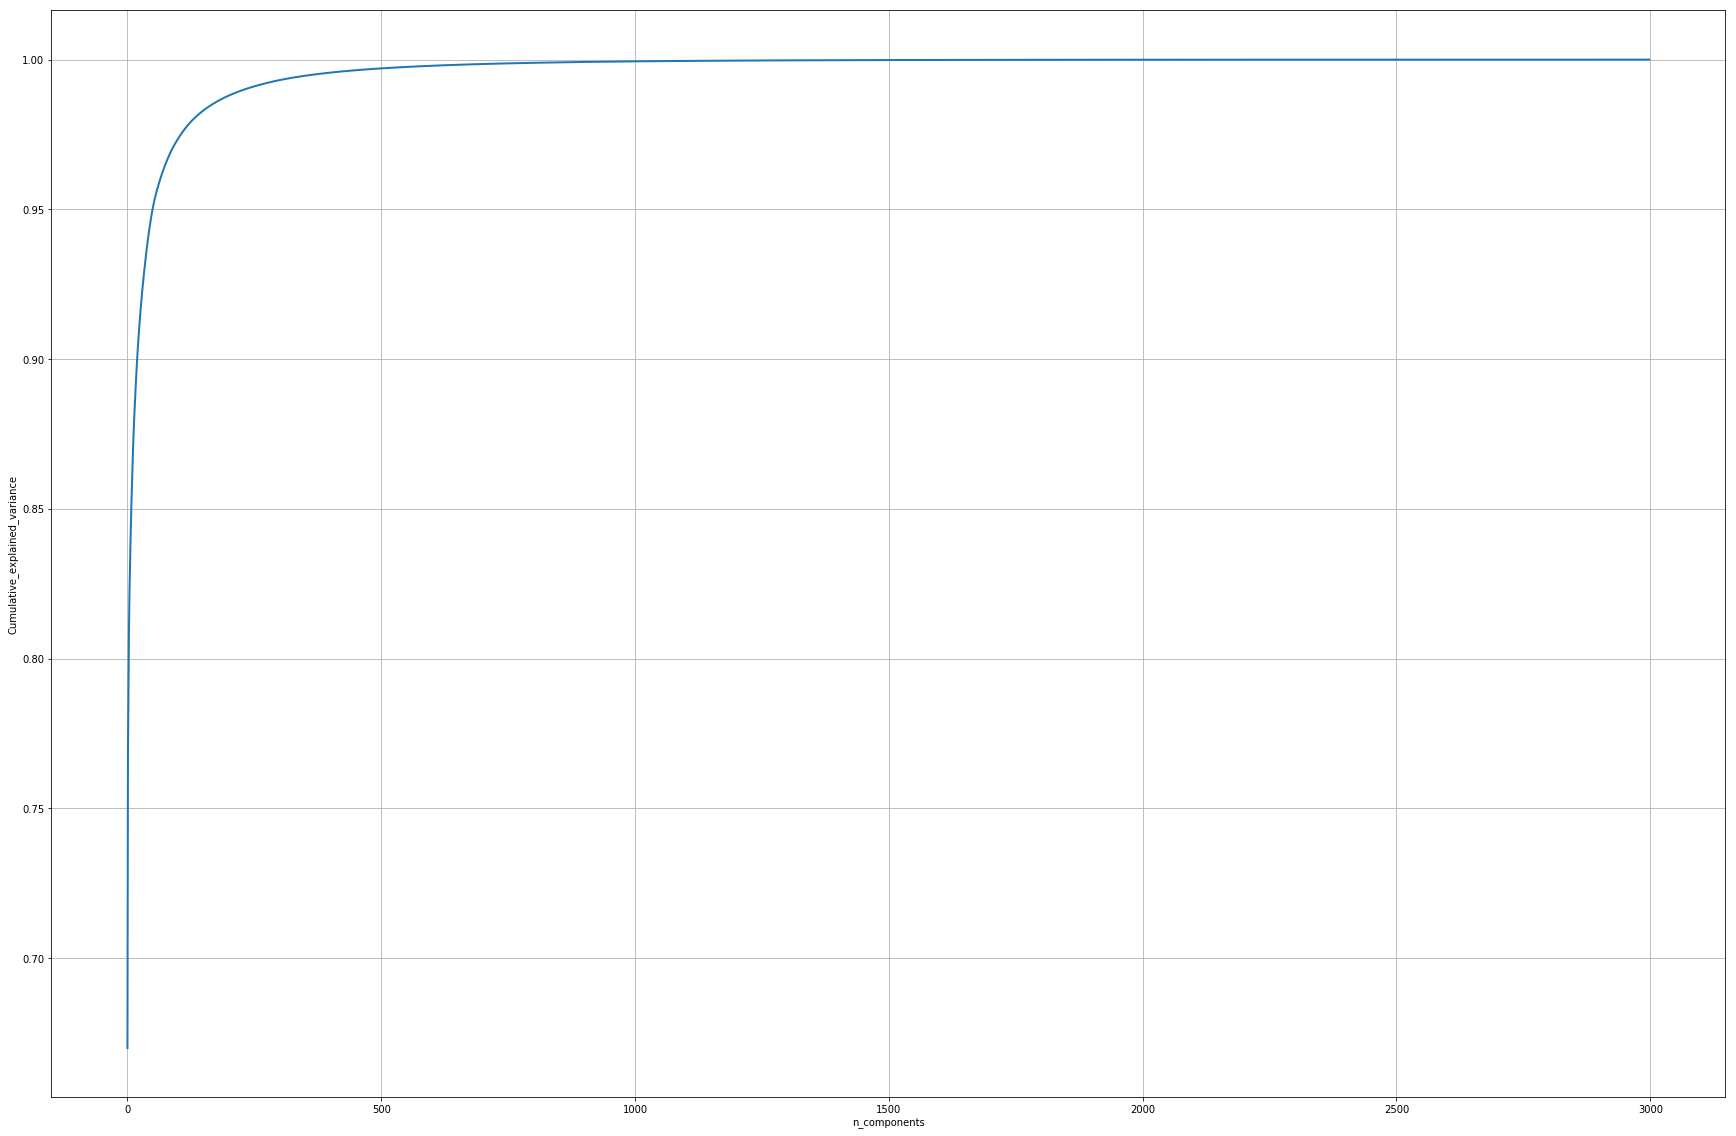

In [37]:
# TSVD for dimensionality redcution (non-visualization)
Tsvd = TruncatedSVD(n_components= df_zero.shape[0]-1)
Tsvd.fit(df_zero)  

percentage_var_explained = Tsvd.explained_variance_ / np.sum(Tsvd.explained_variance_)

cum_var_explained = np.cumsum(percentage_var_explained)

# Plot the svd spectrum
plt.figure(1, figsize=(30, 20))

#Tsvd.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()


In [0]:
#If I take 650-dimensions, approx. 98% of variance is expalined.

By using goal level of explained variance

In [0]:
#Reference: https://chrisalbon.com/machine_learning/feature_engineering/select_best_number_of_components_in_tsvd/

In [0]:
#Selecting The Best Number Of Components For TSVD
# Standardize the feature matrix
X = StandardScaler().fit_transform(df_zero)

# Make sparse matrix
X_sparse = csr_matrix(X)

In [39]:
X_sparse.shape[1]-1

2999

In [0]:
#Run Truncated Singular Value Decomposition
# Create and run an TSVD with one less than number of features
tsvd = TruncatedSVD(n_components=X_sparse.shape[1]-1)
X_tsvd = tsvd.fit(X)

In [0]:
#Create List Of Explained Variances
# List of explained variances
tsvd_var_ratios = tsvd.explained_variance_ratio_

In [0]:
tsvd_var_ratios

array([4.48370511e-01, 2.76818632e-02, 2.12915450e-02, ...,
       2.73328915e-11, 1.65010003e-11, 2.23450257e-12])

In [0]:
#Create Function Calculating Number Of Components Required To Pass Threshold
# Create a function
def select_n_components(var_ratio, goal_var: float) -> int:
    # Set initial variance explained so far
    total_variance = 0.0
    
    # Set initial number of features
    n_components = 0
    
    # For the explained variance of each feature:
    for explained_variance in var_ratio:
        
        # Add the explained variance to the total
        total_variance += explained_variance
        
        # Add one to the number of components
        n_components += 1
        
        # If we reach our goal level of explained variance
        if total_variance >= goal_var:
            # End the loop
            break
            
    # Return the number of components
    return n_components

In [0]:
# Run function
select_n_components(tsvd_var_ratios, 0.95)

656

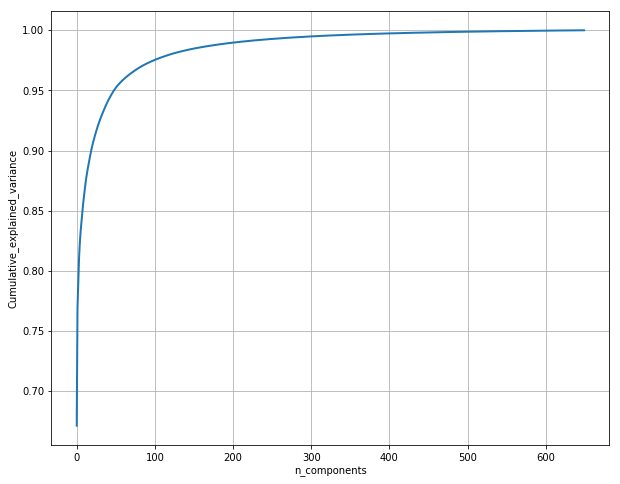

In [42]:
# TSVD for dimensionality redcution (non-visualization)
Tsvd = TruncatedSVD(n_components= 650)
data_tsvd = Tsvd.fit_transform(df_zero)  

percentage_var_explained = Tsvd.explained_variance_ / np.sum(Tsvd.explained_variance_)

cum_var_explained = np.cumsum(percentage_var_explained)

# Plot the svd spectrum
plt.figure(1, figsize=(10, 8))

#Tsvd.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()


### [5.4] Applying k-means clustering

In [0]:
from sklearn.cluster import KMeans

the number of clusters: 9


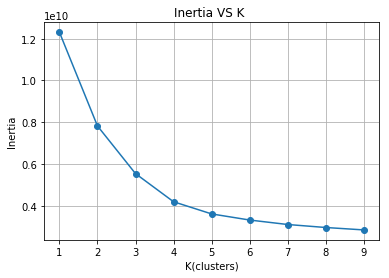

In [45]:
k=range(1,10)
inertia=[]
for i in k:
    model=KMeans(n_clusters=i, n_init=20, n_jobs=-1)
    model.fit(data)
    inertia.append(model.inertia_)
#Calculating "the number of clusters"
n_clusters_ = len(set(model.labels_)) - (1 if -1 in model.labels_ else 0)
print(f"the number of clusters: {n_clusters_}")

#finding best k using elbow method
plt.plot(k, inertia, "-o")
plt.xlabel('K(clusters)')
plt.ylabel('Inertia')
plt.title('Inertia VS K ')
plt.grid()
plt.show()

In [46]:
#https://medium.com/@shritamkumarmund.98/how-dbscan-algorithm-works-2b5bef80fb3
#Computing "the Silhouette Score"
'''A silhouette score ranges from -1 to 1, 
with -1 being the worst score possible and
1 being the best score. Silhouette scores of 0 suggest overlapping clusters.'''
print(f"Silhouette Coefficient: {metrics.silhouette_score(data, model.labels_)}")

Silhouette Coefficient: 0.5856666602061852


### [5.5] Wordclouds of clusters obtained in the above section

In [0]:
Best_Features = [str(i) for i in co_matrix_df["Features"]]

In [0]:
clusters = []
for i in list(set(model.labels_)):
    words = []
    for word in range(model.labels_.shape[0]):
        if (model.labels_[word] == i):
            words.append(Best_Features[word])
    clusters.append(words)

In [0]:
import pickle
import matplotlib.pyplot as plt

In [0]:

dict = clusters
file = open('/content/gdrive/My Drive/Dataset/pkcl/clusters.txt', 'wb')
pickle.dump(dict, file)
file.close()


In [0]:
#saving the clusters in a path. If something went wrong and RAM got crassed then I don't need to make Co-occurrence matrix again
file = open('/content/gdrive/My Drive/Dataset/pkcl/clusters.txt', 'rb')
clusters = pickle.load(file)

In [0]:
cluster_1 = list() 
cluster_2 = list() 
cluster_3 = list() 
cluster_4 = list() 
cluster_5 = list() 
cluster_6 = list() 
cluster_7 = list() 
cluster_8 = list() 
cluster_9 = list() 

for i in range(len(clusters)):
    if i==0:
        for n in clusters[i]:
            cluster_1.append(n)

    elif i ==1:
        for n in clusters[i]:
            cluster_2.append(n)

    elif i ==2:
        for n in clusters[i]:
            cluster_3.append(n)

    elif i ==3:
        for n in clusters[i]:
            cluster_4.append(n)

    elif i ==4:
        for n in clusters[i]:
            cluster_5.append(n)

    elif i ==5:
        for n in clusters[i]:
            cluster_6.append(n)   

    elif i ==6:
        for n in clusters[i]:
            cluster_7.append(n)  
    
    elif i ==7:
        for n in clusters[i]:
            cluster_8.append(n)

    else:
        for n in clusters[i]:
            cluster_9.append(n) 

  


In [6]:
print(f"cluster_1 has {len(cluster_1)} no. of points")
print(f"cluster_2 has {len(cluster_2)} no. of points")
print(f"cluster_3 has {len(cluster_3)} no. of points")
print(f"cluster_4 has {len(cluster_4)} no. of points")
print(f"cluster_5 has {len(cluster_5)} no. of points")
print(f"cluster_6 has {len(cluster_6)} no. of points")
print(f"cluster_7 has {len(cluster_7)} no. of points")
print(f"cluster_8 has {len(cluster_8)} no. of points")
print(f"cluster_9 has {len(cluster_9)} no. of points")


cluster_1 has 2465 no. of points
cluster_2 has 2 no. of points
cluster_3 has 1 no. of points
cluster_4 has 6 no. of points
cluster_5 has 31 no. of points
cluster_6 has 126 no. of points
cluster_7 has 1 no. of points
cluster_8 has 2 no. of points
cluster_9 has 366 no. of points


In [0]:
#https://stackoverflow.com/questions/16645799/how-to-create-a-word-cloud-from-a-corpus-in-python/41727805

Word cloud for cluster_1, words present 2465


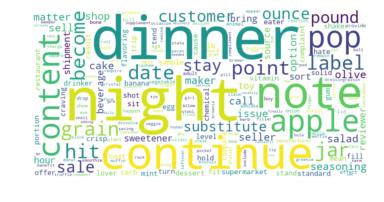

Word cloud for cluster_2, words present 2


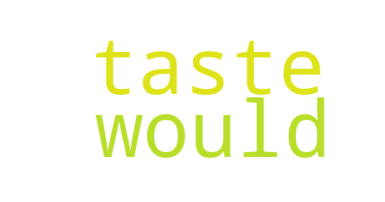

Word cloud for cluster_3, words present 1


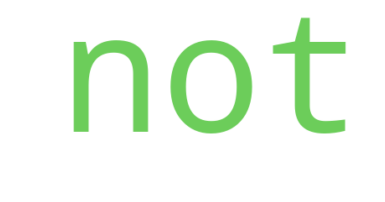

Word cloud for cluster_4, words present 6


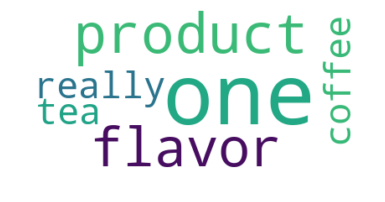

Word cloud for cluster_5, words present 31


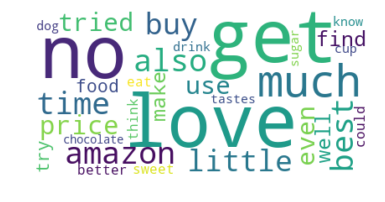

Word cloud for cluster_6, words present 126


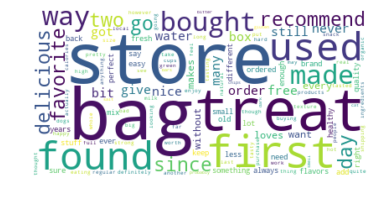

Word cloud for cluster_7, words present 1


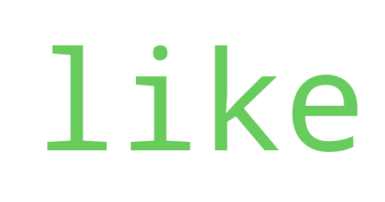

Word cloud for cluster_8, words present 2


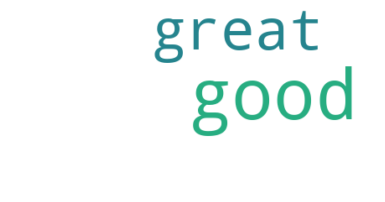

Word cloud for cluster_9, words present 366


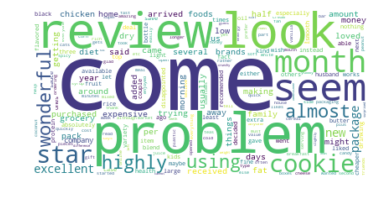

In [11]:
#for cluster_1
print(f"Word cloud for cluster_1, words present {len(cluster_1)}")
data=''
for i in cluster_1:
    data += " " + i
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=400,background_color='white',stopwords = {}).generate(data)
# Display the wordcloud image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
#for cluster_2
print(f"Word cloud for cluster_2, words present {len(cluster_2)}")
data=''
for i in cluster_2:
    data += " " + i
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white",stopwords = {}).generate(data)
# Display the wordcloud image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
#for cluster_3
print(f"Word cloud for cluster_3, words present {len(cluster_3)}")
data=''
for i in cluster_3:
    data += " " + i
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white",stopwords = {}).generate(data)
# Display the wordcloud image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
#for cluster_4
print(f"Word cloud for cluster_4, words present {len(cluster_4)}")
data=''
for i in cluster_4:
    data += " " + i
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white",stopwords = {}).generate(data)
# Display the wordcloud image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#for cluster_5
print(f"Word cloud for cluster_5, words present {len(cluster_5)}")
data=''
for i in cluster_5:
    data += " " + i
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white",stopwords = {}).generate(data)
# Display the wordcloud image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#for cluster_6
print(f"Word cloud for cluster_6, words present {len(cluster_6)}")
data=''
for i in cluster_6:
    data += " " + i
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white",stopwords = {}).generate(data)
# Display the wordcloud image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#for cluster_7
print(f"Word cloud for cluster_7, words present {len(cluster_7)}")
data=''
for i in cluster_7:
    data += " " + i
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white",stopwords = {}).generate(data)
# Display the wordcloud image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#for cluster_8
print(f"Word cloud for cluster_8, words present {len(cluster_8)}")
data=''
for i in cluster_8:
    data += " " + i
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white",stopwords = {}).generate(data)
# Display the wordcloud image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#for cluster_9
print(f"Word cloud for cluster_9, words present {len(cluster_9)}")
data=''
for i in cluster_9:
    data += " " + i
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white",stopwords = {}).generate(data)
# Display the wordcloud image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()



**Observation:**
In cluster_2 wordcloud reprentation we can see the words like 'great' and 'good', in Cluster_4 we have words like "Tea" and "Coffee", In Cluster_6 we have words like "Store" and "Bag". This indicate that all the word are sensible in each clusters. That means the dimention 650 that we got is sensible.

### [5.6] Function that returns most similar words for a given word.

In [0]:
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html
from sklearn.metrics.pairwise import cosine_similarity

In [0]:
from nltk.stem.snowball import SnowballStemmer
from prettytable import PrettyTable

In [0]:
#https://docs.scipy.org/doc/scipy/reference/tutorial/linalg.html
#https://stackoverflow.com/questions/18424228/cosine-similarity-between-2-number-lists

from numpy import linalg

def cosine_similarity(value1, value2):
    
    dotprod = np.dot(value1, value2)
    normprod = linalg.norm(value1) * linalg.norm(value2)
    
    cosin_dist = dotprod/normprod
    cosin_sim = 1 - cosin_dist
    
    return (cosin_sim)

In [0]:
def returns_most_similar_words(word):
    
    sno = SnowballStemmer(language='english')
    input_word=(sno.stem(word.lower()))
    top_words=list(co_matrix_df["Features"])
    
    index = None
    
    if word not in top_words:
        print(f"Word '{word}' is not present.")
    
    else:
        print(f"For word '{word}' most similar words: ")
        for i in range(len(top_words)):
            if input_word == top_words[i]:
                index = i
                
        similarity_values = []
        for i in range(data_tsvd.shape[0]): 
            similarity_values.append(cosine_similarity(data_tsvd[i], data_tsvd[index]))
            
        similarity_values= np.array(similarity_values)
        sorted_index = similarity_values.argsort()

        similarity_words = []
        similarity_scores = []
        for i in range(1, 11):
            similarity_words.append(top_words[sorted_index[i]])
            simscore = 1 - similarity_values[sorted_index[i]]
            similarity_scores.append(simscore)
        
        table = PrettyTable()
        table.add_column("Similar Words", similarity_words)
        table.add_column("Similarity Scores", similarity_scores)
        print(table)
        

In [78]:
returns_most_similar_words("tea")

For word 'tea' most similar words: 
+---------------+--------------------+
| Similar Words | Similarity Scores  |
+---------------+--------------------+
|     coffee    | 0.8301753149476128 |
|      also     | 0.8111822276450024 |
|     still     | 0.7984751211465887 |
|      teas     | 0.7949693316969705 |
|     flavor    | 0.7912622682283627 |
|     course    |  0.78670185355107  |
|      one      | 0.7862521065713114 |
|     olives    | 0.7858296610722836 |
|     really    | 0.7832637730165124 |
|      fact     | 0.7824875122556161 |
+---------------+--------------------+


In [63]:
returns_most_similar_words("like")

For word 'like' most similar words: 
+---------------+--------------------+
| Similar Words | Similarity Scores  |
+---------------+--------------------+
|       ok      | 0.9376718387972346 |
|      good     | 0.9217353395738282 |
|      okay     | 0.9210781252247653 |
|      true     | 0.9172397505304584 |
|    terrible   | 0.9166586374829859 |
|    although   | 0.9159440879894366 |
|     liking    | 0.9130205735600214 |
|    however    | 0.910591390780306  |
|    perhaps    | 0.9092507965002709 |
|      bad      | 0.9091276529724434 |
+---------------+--------------------+


In [64]:
returns_most_similar_words("order")

For word 'order' most similar words: 
+---------------+--------------------+
| Similar Words | Similarity Scores  |
+---------------+--------------------+
|    ordering   | 0.9452310870605548 |
|    purchase   | 0.9288570585402267 |
|      buy      | 0.9089952014740637 |
|    ordered    | 0.9030958673423635 |
|      item     | 0.8965523159058947 |
|   purchasing  | 0.8939019735502052 |
|     buying    | 0.8851537532023238 |
|    reorder    | 0.8812893815751778 |
|    receive    | 0.8787435566604812 |
|     offer     | 0.8757428559124876 |
+---------------+--------------------+


In [81]:
returns_most_similar_words("product")

For word 'product' most similar words: 
+---------------+--------------------+
| Similar Words | Similarity Scores  |
+---------------+--------------------+
|      also     | 0.9035119149083028 |
|      item     | 0.9012054714027643 |
|     stuff     |  0.89901542969623  |
|     still     | 0.8895611661715822 |
|     anyway    | 0.8856121941023972 |
|     course    | 0.8845083900225769 |
|    however    | 0.8840023416704055 |
|     think     | 0.8774229896974832 |
|       us      | 0.8770602351073469 |
|   packaging   | 0.873432140708761  |
+---------------+--------------------+


In [82]:
returns_most_similar_words("shritam")

Word 'shritam' is not present.


# [6] Conclusions

In [92]:
from prettytable import PrettyTable
x= PrettyTable()
y= PrettyTable()

x.field_names = ["Dimensionality reduction technique", "n_components"]
y.field_names = ["Vectorizer", "Model", "No. of Clusters", "Silhouette Coefficient"]

x.add_row(["TruncatedSVD", 650])
y.add_row(["TFIDF", "K-Means", 9, 0.5856666602061852])

print(x)
print()

print("Appled K-means:")
print(y)

+------------------------------------+--------------+
| Dimensionality reduction technique | n_components |
+------------------------------------+--------------+
|            TruncatedSVD            |     650      |
+------------------------------------+--------------+

Appled K-means:
+------------+---------+-----------------+------------------------+
| Vectorizer |  Model  | No. of Clusters | Silhouette Coefficient |
+------------+---------+-----------------+------------------------+
|   TFIDF    | K-Means |        9        |   0.5856666602061852   |
+------------+---------+-----------------+------------------------+
